In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from sklearn.linear_model import LinearRegression

%matplotlib inline

sns.set_style('whitegrid')

In [2]:
heating_dict = pd.read_excel(os.getcwd()+'\data_clean\category_dictionary.xlsx',sheetname='heatingorsystemtypeid')
property_dict = pd.read_excel(os.getcwd()+'\data_clean\category_dictionary.xlsx',sheetname='propertylandusetypeid')

In [3]:
growth_adj = pd.read_csv(os.getcwd() + '\data_clean\growth.csv')
growth_adj = growth_adj.set_index('zipcode')
growth_adj.columns = ['%']

sales_adj = pd.read_csv(os.getcwd() + '\data_clean\la_sales_conversions.csv')
sales_adj = sales_adj.drop('Unnamed: 0',axis=1)

In [5]:
class Valuation:
    
    def __init__(self):
        self.MainTrainingSet = pd.read_csv(os.getcwd()+'\data_clean\ca_properties_2016.csv')
        self.TrainingSet = self.MainTrainingSet
        self.TrainingSet = self.TrainingSet.set_index('zipcode')
        self.categories = ['Zip Code','Heating Type','Property Zoning Type','Unit Count','Pool Count']
        self.features = ['calculatedfinishedsquarefeet','bathroomcnt','bedroomcnt','buildingqualitytypeid','lotsizesquarefeet',
           'latitude','longitude','yearbuilt','roomcnt','totalassessedvalue']
        
        self.filter_count = 0
    
    
        
    # input_property is a dictionary containing the characteristics of the property we want to value, as well as 
    # its listing price. we must also map values from property type and heating type to the integers that are used 
    # in the dataset to denote the different categories
    
    # we can automate the if statements in a for loop, but we will leave it explicit for clarity's sake
    # we order the if statements so that in general, the filters which are the MOST reducing
    # are applied first. this is to ensure that we reduce the dataset as much as possible.
    # (an alternate version of this could better ensure that we find the optimal combination of filters, but this
    # is a practical heuristic for this version and in most cases will return the same result)
    
    def fit(self,input_property):
        self.characteristics = input_property
        self.heatingid = heating_dict[heating_dict['description']==input_property['heatingorsystemtypeid']]['id'].values[0]
        self.propertyid = property_dict[property_dict['description']==input_property['propertylandusetypeid']]['id'].values[0]
        self.filters_used = []
        
        # categorical filters
        
        if len(self.TrainingSet.loc[input_property['zipcode']]) > 1000:
            self.TrainingSet = self.TrainingSet.loc[input_property['zipcode']]
            self.filter_count += 1
            self.filters_used.append(self.categories[0])
        
        self.lenbefore = len(self.TrainingSet)
        
        if len(self.TrainingSet[self.TrainingSet['heatingorsystemtypeid']==self.heatingid]) > 1000:
            self.TrainingSet = self.TrainingSet[self.TrainingSet['heatingorsystemtypeid']==self.heatingid]
            self.filter_count += 1
            self.filters_used.append(self.categories[1])
            
        if len(self.TrainingSet[self.TrainingSet['propertylandusetypeid']==self.propertyid]) > 1000:
            self.TrainingSet = self.TrainingSet[self.TrainingSet['propertylandusetypeid']==self.propertyid]
            self.filter_count += 1
            self.filters_used.append(self.categories[2])
            
        if len(self.TrainingSet[self.TrainingSet['unitcnt']==input_property['unitcnt']]) > 1000:
            self.TrainingSet = self.TrainingSet[self.TrainingSet['unitcnt']==input_property['unitcnt']]
            self.filter_count += 1
            self.filters_used.append(self.categories[3])
        
        if len(self.TrainingSet[self.TrainingSet['poolcnt']==input_property['poolcnt']]) > 1000:
            self.TrainingSet = self.TrainingSet[self.TrainingSet['poolcnt']==input_property['poolcnt']]
            self.filter_count += 1
            self.filters_used.append(self.categories[4])
            
        if input_property['buildingqualitytypeid'] == '':
            input_property['buildingqualitytypeid'] = self.TrainingSet['buildingqualitytypeid'].mean()
            self.characteristics['buildingqualitytypeid'] = self.TrainingSet['buildingqualitytypeid'].mean()
        
        self.lenafter = len(self.TrainingSet)
        self.reduction = (self.lenbefore - self.lenafter)/self.lenbefore
        
        self.features_to_use = self.TrainingSet[self.features].corr()['totalassessedvalue'][np.abs(self.TrainingSet[self.features].corr()['totalassessedvalue']) > 0.2]
        self.features_to_use = self.features_to_use[self.features_to_use.index != 'totalassessedvalue']
        
        self.lr = LinearRegression()
        self.lr.fit(self.TrainingSet[self.features_to_use.index],self.TrainingSet['totalassessedvalue'])
        
        self.input_features = []
        for feature in self.features_to_use.index:
            self.input_features.append(input_property[feature])
            
        self.growth = growth_adj.loc[input_property['zipcode']][0]
        self.sales_constant = np.median(sales_adj.median())/np.median(self.MainTrainingSet.set_index('zipcode').loc[input_property['zipcode']]['totalassessedvalue'])
        self.suggested_saleprice = self.lr.predict(pd.DataFrame(self.input_features)[0].reshape(1,-1)[0])[0]*self.growth*self.sales_constant
        self.SD = np.sqrt(self.lr.residues_/len(self.TrainingSet[self.features_to_use.index])-1)*self.growth*self.sales_constant
        self.deviations = (input_property['listprice'] - self.suggested_saleprice)/self.SD
        self.CI70 = [self.suggested_saleprice - self.SD, self.suggested_saleprice + self.SD]
        
    def plots(self):
        if len(self.features_to_use) < 10:
            self.fig = plt.figure(figsize=(16,10))
        else:
            self.fig = plt.figure(figsize=(16,12))
        for i in range(len(self.features_to_use.index)):
            self.x = self.TrainingSet.loc[self.characteristics['zipcode']][self.features_to_use.index[i]]
            self.y = self.TrainingSet.loc[self.characteristics['zipcode']]['totalassessedvalue']
            self.lr.fit(self.x.to_frame(),self.y.to_frame())
            self.xl = np.linspace(min(self.x),max(self.x),2)
            self.yl = self.xl*self.lr.coef_[0] + self.lr.intercept_
    
            if len(self.features_to_use) < 10:
                self.ax = self.fig.add_subplot(3,3,i+1)
            else:
                self.ax = self.fig.add_subplot(4,3,i+1)
            
            self.ax.scatter(self.TrainingSet.loc[self.characteristics['zipcode']][self.features_to_use.index[i]],self.TrainingSet.loc[self.characteristics['zipcode']]['totalassessedvalue'],alpha=0.15)
            self.ax.plot(self.xl,self.yl,'k')
            self.ax.plot(self.characteristics[self.features_to_use.index[i]],self.characteristics['listprice'],'*r')
            self.ax.set_xlabel(str(self.features_to_use.index[i]))
    
        self.fig = plt.tight_layout()

    def analyze(self):
        print('Mean Predicted Sales Price: ' + str(int(self.suggested_saleprice)))
        print('List Price of ' + str(self.characteristics['listprice']) + ' is %.2f' % self.deviations + ' SDs above/below mean')
        print('70% confidence interval: ' + str(self.CI70))
        print(str(len(self.TrainingSet)) + ' training examples used')
        print('Reduction in training set size since Zip Code filter: %.2f' % (self.reduction*100)+'%')

In [6]:
input_example = {'zipcode':91304,'propertylandusetypeid':'Single Family Residential',
                 'unitcnt':1,'heatingorsystemtypeid':'Central','poolcnt':1,
                 'calculatedfinishedsquarefeet':2782, 'bedroomcnt':6,
                 'bathroomcnt':3.5,'latitude':34.213,'longitude':-118.637,'yearbuilt':1963,
                 'lotsizesquarefeet':10890,'buildingqualitytypeid':5,'listprice':969000}

In [7]:
x = Valuation()
x.fit(input_example)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:81: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
x.analyze()

Mean Predicted Sales Price: 923438
List Price of 969000 is 0.17 SDs above/below mean
70% confidence interval: [651160.89872875053, 1195715.7301543583]
3005 training examples used
Reduction in training set size since Zip Code filter: 68.46%


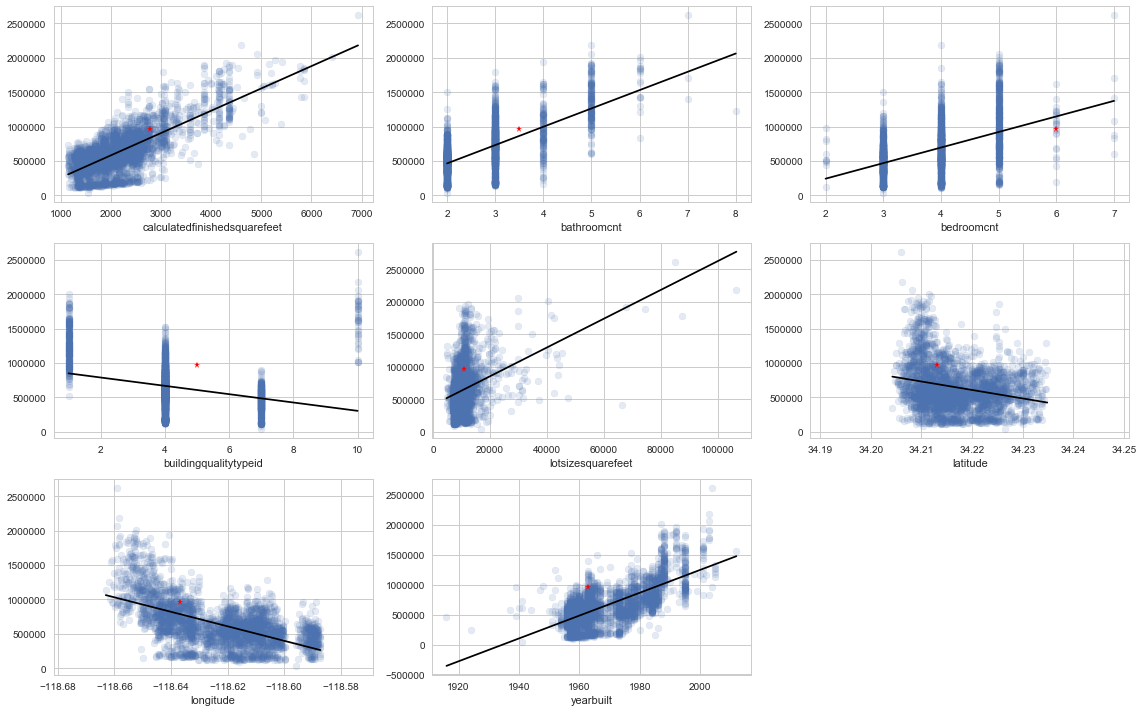

In [9]:
x.plots()

In [12]:
input_example2 = {'zipcode':91304,'propertylandusetypeid':'Single Family Residential',
                 'unitcnt':1,'heatingorsystemtypeid':'Central','poolcnt':1,
                 'calculatedfinishedsquarefeet':2782, 'bedroomcnt':6,
                 'bathroomcnt':3.5,'latitude':34.213,'longitude':-118.637,'yearbuilt':1963,
                 'lotsizesquarefeet':10890,'buildingqualitytypeid':'','listprice':969000}

In [13]:
y = Valuation()
y.fit(input_example2)
y.analyze()

Mean Predicted Sales Price: 921104
List Price of 969000 is 0.18 SDs above/below mean
70% confidence interval: [648827.24240077566, 1193382.0738263833]
3005 training examples used
Reduction in training set size since Zip Code filter: 68.46%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:81: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


In [14]:
test = pd.read_excel(os.getcwd()+'\data_clean\properties test set.xlsx')
test = test.fillna('')

In [15]:
test.head()

,zipcode,propertylandusetypeid,unitcnt,heatingorsystemtypeid,poolcnt,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,latitude,longitude,yearbuilt,lotsizesquarefeet,buildingqualitytypeid,listprice
0,91344,Single Family Residential,1,Central,1,1680,4,2,34.273,-118.509,1954,7905,,664500
1,90046,Single Family Residential,1,None,1,2510,3,3,34.126,-118.360,1957,8929,,2795000
2,91367,Single Family Residential,1,Central,0,2034,4,3,34.183,-118.638,1959,7500,,898000
3,91344,Single Family Residential,1,Central,1,4416,5,6,34.287,-118.520,1999,20038,,1529000
4,91342,Single Family Residential,1,Central,1,1303,4,2,34.292,-118.456,1959,7258,,550000


In [16]:
test.iloc[0].to_dict()

{'bathroomcnt': 2,
 'bedroomcnt': 4,
 'buildingqualitytypeid': '',
 'calculatedfinishedsquarefeet': 1680,
 'heatingorsystemtypeid': 'Central',
 'latitude': 34.273000000000003,
 'listprice': 664500,
 'longitude': -118.509,
 'lotsizesquarefeet': 7905,
 'poolcnt': 1,
 'propertylandusetypeid': 'Single Family Residential',
 'unitcnt': 1,
 'yearbuilt': 1954,
 'zipcode': 91344}

In [17]:
results = pd.DataFrame(columns=['Zip Code','Suggested Price','List Price','+/- SDs'])

In [23]:
for i in range(test.index.max()+1):
    temp = Valuation()
    temp.fit(test.iloc[i].to_dict())
    results = results.append({'Zip Code':test.iloc[i]['zipcode'],'Suggested Price':temp.suggested_saleprice,'List Price':test.iloc[i]['listprice'],'+/- SDs':temp.deviations},ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:81: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has

In [24]:
results['id'] = list(range(20))

In [25]:
results['Suggested Price'] = results['Suggested Price'].map('${:,.2f}'.format)
results['List Price'] = results['List Price'].map('${:,.2f}'.format)
results['Zip Code'] = results['Zip Code'].astype(int)

In [31]:
# filter to the properties predicted to be underpriced. i.e. list price < suggested price

results[results['+/- SDs']<0].sort_values('+/- SDs')

,Zip Code,Suggested Price,List Price,+/- SDs,id
3,91344,"$1,809,985.56","$1,529,000.00",-1.023408,3
12,91304,"$680,158.51","$439,000.00",-0.980891,12
6,91343,"$948,010.60","$749,950.00",-0.748384,6
11,91401,"$789,285.50","$549,000.00",-0.714486,11
5,90057,"$559,544.14","$390,000.00",-0.331496,5
16,91406,"$805,109.92","$745,000.00",-0.194159,16
4,91342,"$583,321.25","$550,000.00",-0.117995,4
14,91352,"$506,970.81","$469,964.00",-0.105863,14
